## **ARIMA MODEL**

In [ ]:
from datetime import datetime
import numpy as np             #for numerical computations like log,exp,sqrt etc
import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18, 9

In [ ]:
 #Load the CSV file
path = "/content/bin.csv" # Path in Colab environment
# from google.colab import files
# uploaded = files.upload()
# import io
# dataset = pd.read_csv(io.StringIO(uploaded['bin.csv'].decode('utf-8'))) # to read csv file from local directory
dataset = pd.read_csv(path)
data = dataset[['eventDate', 'FillPercentage']]
print(len(data))
data['eventDate'] = pd.to_datetime(data['eventDate'])
df = data.set_index('eventDate')

16801


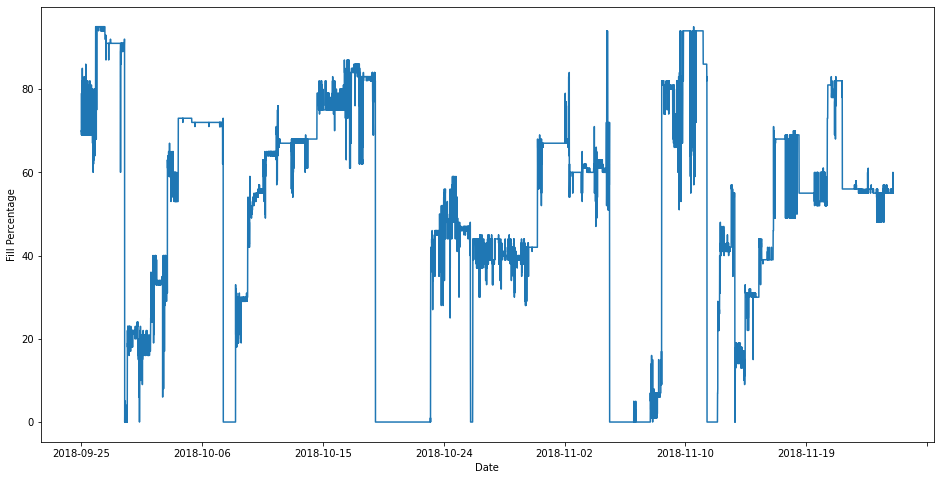

In [ ]:
# Plot for FillPercentage value vs Date
plt.figure(figsize=(16,8))
df['FillPercentage'].plot()
plt.xlabel('Date')
plt.ylabel('Fill Percentage')
plt.show()

# Data Preprocessing

In [ ]:
#Determine rolling statistics
rolmean = df['FillPercentage'].rolling(window=12).mean() #window size 12 denotes 12 months, giving rolling mean at yearly level
rolstd = df['FillPercentage'].rolling(window=12).std()
print(rolmean,rolstd)

eventDate
2018-09-25          NaN
2018-09-25          NaN
2018-09-25          NaN
2018-09-25          NaN
2018-09-25          NaN
                ...    
2018-11-25    55.166667
2018-11-25    55.166667
2018-11-25    55.583333
2018-11-25    55.583333
2018-11-25    55.666667
Name: FillPercentage, Length: 16801, dtype: float64 eventDate
2018-09-25         NaN
2018-09-25         NaN
2018-09-25         NaN
2018-09-25         NaN
2018-09-25         NaN
                ...   
2018-11-25    0.389249
2018-11-25    0.389249
2018-11-25    1.443376
2018-11-25    1.443376
2018-11-25    1.435481
Name: FillPercentage, Length: 16801, dtype: float64


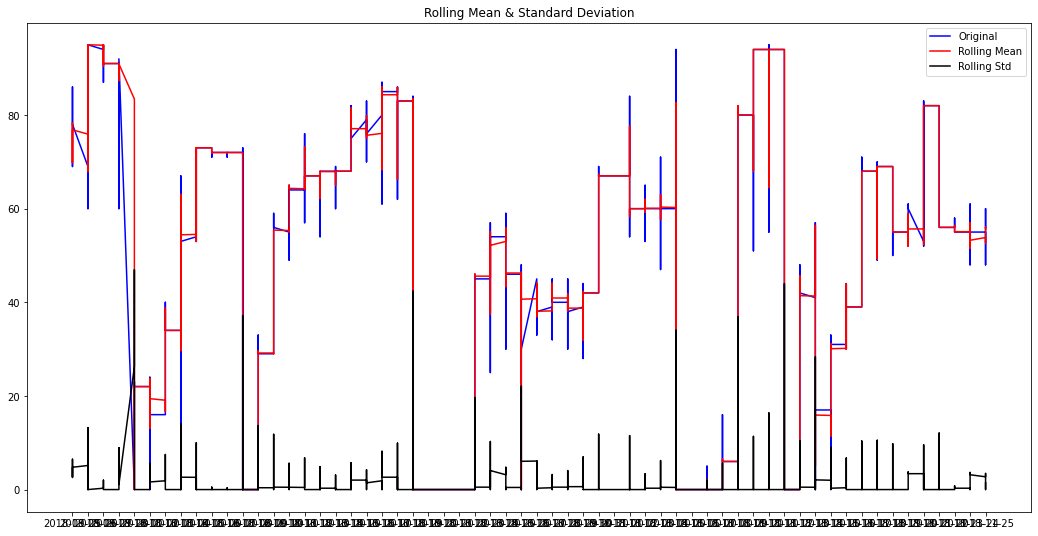

In [ ]:
#Plot rolling statistics
plt.figure( figsize=(18,9))
orig = plt.plot(df['FillPercentage'], color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [ ]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df['FillPercentage'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                    -4.330653
p-value                            0.000393
#Lags Used                        26.000000
Number of Observations Used    16774.000000
Critical Value (1%)               -3.430740
Critical Value (5%)               -2.861712
Critical Value (10%)              -2.566862
dtype: float64


FillPercentage    0
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


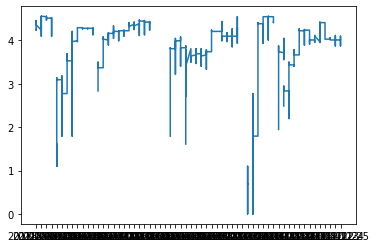

In [ ]:
#Estimating trend
df_logScale = np.log(df)
print(df_logScale.isnull().sum())
df_logScale.dropna(inplace=True)
plt.plot(df_logScale)

# ACF and PACF Plots

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:669: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


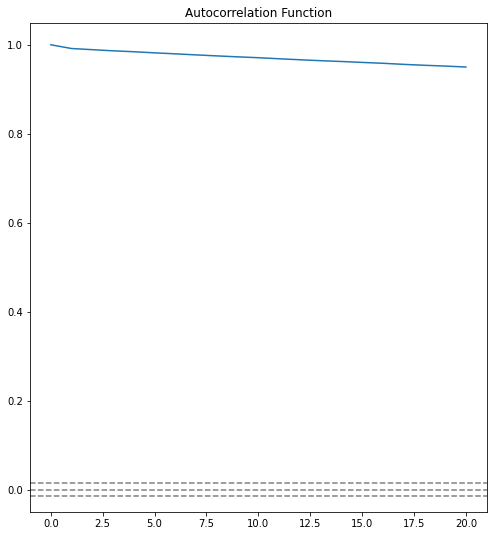

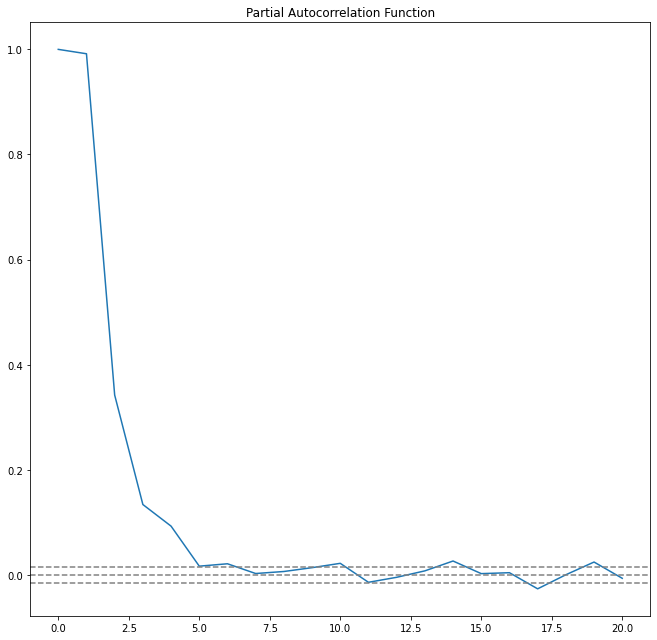

In [ ]:
#ACF and PACF plots

lag_acf = acf(df['FillPercentage'], nlags=20)
lag_pacf = pacf(df['FillPercentage'], nlags=20, method='ols')

#Plot ACF:
plt.figure(figsize =(18,9))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.figure(figsize =(18,9))
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout() 

# Model Implementation

In [ ]:
#auto_arima to find the optimal p,d,q values and build ARIMA model
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=8, max_q=8, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=88341.133, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=183380.815, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=162110.407, Time=1.54 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=88335.778, Time=1.58 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=88331.954, Time=7.16 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=88325.876, Time=8.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=1.35 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=88333.308, Time=5.71 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=88320.976, Time=6.65 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=88319.382, Time=4.96 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=88342.316, Time=6.51 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

Plotting AR model


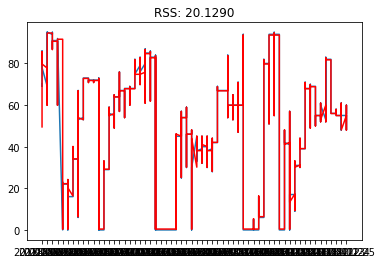

In [ ]:
#AR Model
model = ARIMA(df, order=(1,0,0))
results_AR = model.fit(disp=-1)
plt.plot(df['FillPercentage'])
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df['FillPercentage'])))
print('Plotting AR model')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

Plotting ARIMA model


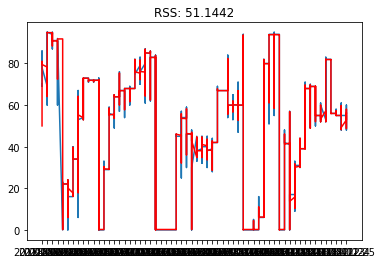

In [ ]:
# AR+I+MA = ARIMA model
model = ARIMA(df['FillPercentage'], order=(2,0,3))
results_ARIMA = model.fit(disp=-1)
plt.plot(df['FillPercentage'])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df['FillPercentage'])))
print('Plotting ARIMA model')

In [ ]:
#Summary of the ARIMA Model Built
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:         FillPercentage   No. Observations:                16801
Model:                     ARMA(2, 3)   Log Likelihood              -44144.819
Method:                       css-mle   S.D. of innovations              3.348
Date:                Fri, 04 Dec 2020   AIC                          88303.639
Time:                        19:53:56   BIC                          88357.743
Sample:                             0   HQIC                         88321.490
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   49.9949      6.086      8.215      0.000      38.066      61.923
ar.L1.FillPercentage     0.1931      0.085      2.284      0.022       0.027       0.359
ar.L2.FillPe

In [ ]:
#  ARIMA Model
import numpy as dragon
import statsmodels.tsa.api as smt
import math
size = int(len(df)-10)
train_arima, test_arima = df[0:size], df[size:len(df)]
history = [x for x in train_arima]
# print(history)
predictions = list()
originals = list()
error_list = list()
mse_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
print(test_arima['FillPercentage'][0])
for t in range(len(test_arima)):
    model = smt.ARMA(df[size:len(df)], order=(2,0, 3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    # print("out",output[0])
    pred_value = output[0]
    pred_value1 = pd.Series(pred_value, copy=True)
    print(pred_value1.head())
    
        
    original_value = test_arima['FillPercentage'][t]
    history.append(original_value)
    
    print("exp",original_value)
    
    error = ((abs(pred_value - original_value)) / original_value) *100
    mse = ((abs(pred_value - original_value)) / original_value)
    mse_list.append(mse)
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))

#Calculating the Forecast Accuracy    
print('\n Means Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
print('MSE:', (sum(mse_list)/float(len(mse_list)))) 
print('RMSE:',(math.sqrt(sum(mse_list)/float(len(mse_list)))))



Printing Predicted vs Expected Values...


56
0    55.795536
dtype: float64
exp 56
predicted = 55.795536,   expected = 56.000000,   error = 0.365114  %
0    55.795536
dtype: float64
exp 55
predicted = 55.795536,   expected = 55.000000,   error = 1.446430  %
0    55.795536
dtype: float64
exp 56
predicted = 55.795536,   expected = 56.000000,   error = 0.365114  %
0    55.795536
dtype: float64
exp 55
predicted = 55.795536,   expected = 55.000000,   error = 1.446430  %
0    55.795536
dtype: float64
exp 55
predicted = 55.795536,   expected = 55.000000,   error = 1.446430  %
0    55.795536
dtype: float64
exp 55
predicted = 55.795536,   expected = 55.000000,   error = 1.446430  %


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

0    55.795536
dtype: float64
exp 55
predicted = 55.795536,   expected = 55.000000,   error = 1.446430  %
0    55.795536
dtype: float64
exp 60
predicted = 55.795536,   expected = 60.000000,   error = 7.007439  %
0    55.795536
dtype: float64
exp 55
predicted = 55.795536,   expected = 55.000000,   error = 1.446430  %
0    55.795536
dtype: float64
exp 56
predicted = 55.795536,   expected = 56.000000,   error = 0.365114  %

 Means Error in Predicting Test Case Articles : 1.678136  %
MSE: [0.01678136]
RMSE: 0.12954288453043128


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# ARIMA Forecated results
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

eventDate
2018-09-25    49.994879
2018-09-25    69.830411
2018-09-25    69.888477
2018-09-25    69.297019
2018-09-25    75.028439
dtype: float64


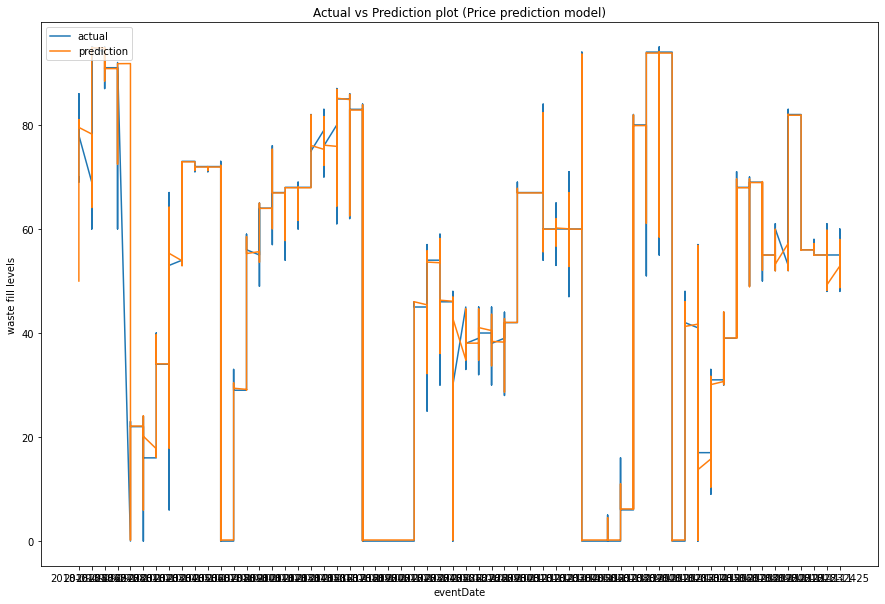

In [ ]:
# Plot of Actual vs Predicted Values
plt.figure(figsize = (15,10))
plt.plot(df)
plt.plot(predictions_ARIMA_diff)
plt.title('Actual vs Prediction plot')
plt.ylabel('waste fill levels')
plt.xlabel('eventDate')
plt.legend(['actual', 'prediction'], loc='upper left')
plt.show()

# Model Evaluation

In [ ]:
# Evaluation metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

forecast_accuracy(df['FillPercentage'], predictions_ARIMA_diff)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: Support for multi-dimensional indexing 

{'mae': 1.1658169857453924,
 'mape': 0.2034472718930649,
 'me': -0.0030441185166198603,
 'mpe': -0.12354420515697011,
 'rmse': 3.351773455717107}

# Future Forecast

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


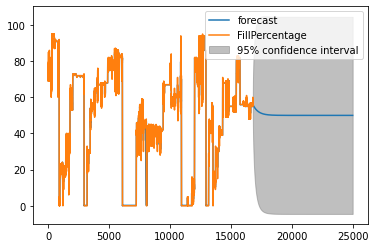

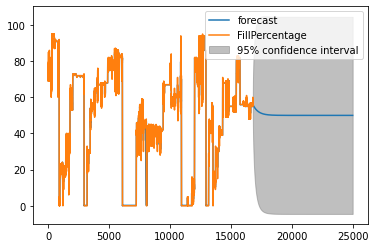

In [ ]:
#And we want to forecast for additional 7000 data points or 1 month.
fc = model_fit.predict(start=1, end=17000, dynamic=False)
results_ARIMA.plot_predict(1,25000) 